##### John Franklin Crenshaw

.

Physics 566 Problem Set 4

March 1, 2019

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

In [2]:
# Plot aesthetics
plt.style.use('jfc') # a style sheet I have defined on my computer
%config InlineBackend.figure_format = 'retina'
np.set_printoptions(precision=3)

***
#### (1) CP 5.21, parts a & b
###### *Electric field of a charge distribution*

Given a charge distribution, you can calculate the potential $\phi = q/4\pi\epsilon_0r$ as a function of position, then take the gradient to find the electric field: $\vec{E} = - \nabla \phi$.

Below I calculate and plot the potential due to a +1C charge at (-5cm,0cm) and a -1C charge at (5cm,0cm). Then I calculate the electric field from the potential by using the central difference formula for the derivative.

In [3]:
# positions of charges (cm)
r1 = [-5,0]
r2 = [5,0]

k = 9e13 # Coulomb constant, N*cm^2/C^2

# Calculate potential
Vgrid = np.zeros((101,101))
for i,x in enumerate(range(-50,51)):
    for j,y in enumerate(range(-50,51)):
        
        # calculate distances
        d1 = np.sqrt( (x-r1[0])**2 + (y-r1[1])**2 )
        d2 = np.sqrt( (x-r2[0])**2 + (y-r2[1])**2 )
        
        # if distances aren't zero, calculate potential
        if d1 != 0 and d2 != 0:
            V = k*(1/d1 - 1/d2)
            Vgrid[j,i] = V

            
# Calculate field
# use central difference for derivative
Exgrid = np.zeros((99,99))
Eygrid = np.zeros((99,99))
for i,x in enumerate(range(-49,50)):
    for j,y in enumerate(range(-49,50)):
        
        Ex = -(Vgrid[j,i+1]-Vgrid[j,i-1])/2
        Exgrid[j,i] = Ex
        
        Ey = -(Vgrid[j+1,i]-Vgrid[j-1,i])/2
        Eygrid[j,i] = Ey

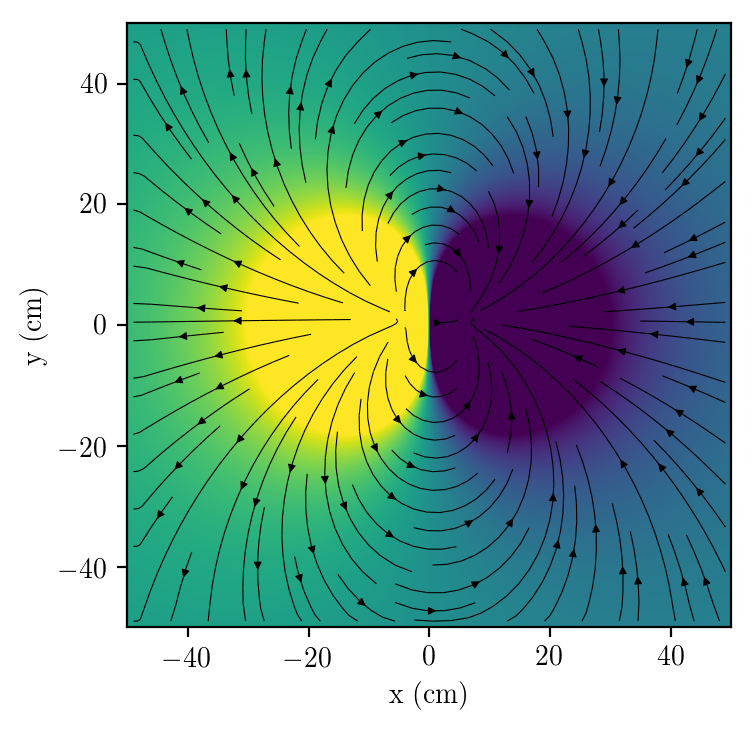

In [4]:
fig1, ax1 = plt.subplots(1,1)

# plot the potential
ax1.imshow(Vgrid,vmin=-1e12,vmax=1e12,origin='lower',
           extent=(-50,50,-50,50),interpolation="Gaussian")

# visualize field
xx = np.arange(-49,50)
ax1.streamplot(xx,xx,Exgrid,Eygrid,density=1.1,color='black',
               linewidth=0.4,arrowsize=0.6)

ax1.set_xlabel("x (cm)")
ax1.set_ylabel("y (cm)")

plt.show()

***
#### (2) CP 6.1
###### *Solving a system of equations for a circuit of resistors*

In the text we are given a circuit with a system of resistors. We want to solve the following system of equations for $V_1$, $V_2$, $V_3$, and $V_4$:
$$ \frac{V_1 - V_2}{R} + \frac{V_1 - V_3}{R} + \frac{V_1 - V_4}{R} + \frac{V_1 - V_+}{R} = 0 $$
$$ \frac{V_2 - V_1}{R} + \frac{V_2 - V_4}{R} + \frac{V_2 - V_-}{R} = 0 $$
$$ \frac{V_3 - V_1}{R} + \frac{V_3 - V_4}{R} + \frac{V_3 - V_+}{R} = 0 $$
$$ \frac{V_4 - V_1}{R} + \frac{V_4 - V_2}{R} + \frac{V_4 - V_3}{R} + \frac{V_4 - V_-}{R} = 0 $$



Multiplying by R, we get
$$ 4 V_1 - V_2 - V_3 - V_4 = V_+ $$
$$ - V_1 + 3 V_2 - V_4 = V_- $$
$$ - V_1 + 3 V_3 - V_4 = V_+ $$
$$ - V_1 - V_2 - V_3 + 4V_4 = V_- $$

We can then use Gaussian elimination and back substitution.

In [5]:
A = np.array([[ 4,-1,-1,-1],
              [-1, 3, 0,-1],
              [-1, 0, 3,-1],
              [-1,-1,-1, 4]],float)
v = np.array([5,0,5,0],float)
N = len(v)

# Gaussian elimination
for i in range(N):
    
    # divide by the diagonal element
    div = A[i,i]
    A[i,:] /= div
    v[i] /= div
    
    # Now subtract from the lower rows
    for j in range(i+1,N):
        mult = A[j,i]
        A[j,:] -= mult*A[i,:]
        v[j] -= mult*v[i]
        
# Backsubstitution
x = np.empty(N)
for i in range(N-1,-1,-1):
    x[i] = v[i]
    for j in range(i+1,N):
        x[i] -= A[i,j]*x[j]
        

print("x =[{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}]".format(
                                            x[0],x[1],x[2],x[3]))

x =[3.000, 1.667, 3.333, 2.000]


Thus, our result:
$$ V_1 = 3\ \text{V} $$
$$ V_2 = \frac{5}{3}\ \text{V} $$
$$ V_3 = \frac{10}{3}\ \text{V} $$
$$ V_4 = 2\ \text{V} $$

***
#### (3) CP 6.2
###### *Solving a system of equations with partial pivotting*

Gaussian elimination involves dividing by the value of the diagonal element. If there is a 0 on the diagonal, this obviously creates a problem. This can (usually) be solved via partial pivotting. Each time you go to a new row, look at all of the rows below it, and swap with the row that has the greatest magnitude in the relevant column. 

Here I recreate the Gaussian elimination from above, and add in a partial pivotting step. I also put it into a function as I want to use it twice

In [6]:
def gauss_elim_w_pivot(A_,v):
    """Solve system of equations Ax=v, using Gaussian 
    elimination and partial pivotting."""
    
    # N equations
    N = len(v)
        
    # Gaussian elimination
    for i in range(N):
        
        # --- partial pivoting ---
        # which row has greatest mag. in this column below
        # the diagonal?
        pivot_list = [abs(A[j,i]) for j in range(i,N)]
        index = np.argmax(pivot_list) + i
        # swap that row with this one
        A[i,:], A[index,:] = A[index,:].copy(), A[i,:].copy()
        v[i], v[index] = v[index], v[i]
        
        # divide by diagonal element
        div = A[i,i]
        A[i,:] /= div
        v[i] /= div
        
        # now subtract from the lower rows
        for j in range(i+1,N):
            mult = A[j,i]
            A[j,:] -= mult*A[i,:]
            v[j] -= mult*v[i]
            
    # Backsubstitution
    x = np.empty(N)
    for i in range(N-1,-1,-1):
        x[i] = v[i]
        for j in range(i+1,N):
            x[i] -= A[i,j]*x[j]
            
    return x

First, I solve the same system from question 1, to confirm that it works.

In [7]:
A = np.array([[ 4,-1,-1,-1],
              [-1, 3, 0,-1],
              [-1, 0, 3,-1],
              [-1,-1,-1, 4]],float)
v = np.array([5,0,5,0],float)
x = gauss_elim_w_pivot(A,v)
print("x =[{0:.3f}, {1:.3f}, {2:.3f}, {3:.3f}]".format(
                                            x[0],x[1],x[2],x[3]))

x =[3.000, 1.667, 3.333, 2.000]


This is the same result as before!

Now I solve a system that has a 0 on the first diagonal. Notice that the previous code could not have solved this system, as it would've resulted in a division by zero.

In [8]:
A = np.array([[ 0, 1, 4, 1],
              [ 3, 4,-1,-1],
              [ 1,-4, 1, 5],
              [ 2,-2, 1, 3]],float)
v = [-4,3,9,7]
x = gauss_elim_w_pivot(A,v)
print(x)

[ 1.619 -0.429 -1.238  1.381]


Our result: $w \approx 1.619,\ x \approx -0.429,\ y \approx -1.238,\ z \approx 1.381$

***
#### (4) CP 6.3, a & b
###### *LU decomposition*

If you want to solve the matrix equation $Ax=v$ for the same $A$ and many different $b$'s, you don't need to perform the Gaussian elimination each time. The matrix $A$ will also have the same operations applied on it every time, and will thus always end up as the same upper triangular matrix. Instead, you only need to keep track of the swaps, divisions, and subtractions you performed on $A$, and perform them on each new $v$. Equivalently, you can keep track of the inverses of these operations, and write them in a lower triangular matrix $L$. This allows you to decompose $A$ into a product of lower and upper matrices: $A = LU$. This is called LU decomposition. Details are in the text.

Once you have $A = LU$, you can solve $Ax=v$ via
$$ Ax=LUx=L(Ux)=Ly=v. $$
Since L is lower triangular, $Ly=v$ can be quickly solved via back-substitution. Once you have $y$, you can quickly solve $Ux=y$ via back substitution. We do this below.

First I write a function to decompose the matrix A.

In [9]:
def LU_decomposition(A):
    """Perform LU decomposition on the matrix A"""
    
    U = A.copy()
    
    # N rows
    N = len(U)
    L = np.zeros(U.shape)
    
    # Gaussian elimination
    for i in range(N):
        
        for j in range(i,N):
            L[j,i] = U[j,i]
        
        # divide by the diagonal element
        div = U[i,i]
        U[i,:] /= div
    
        # Now subtract from the lower rows
        for j in range(i+1,N):
            mult = U[j,i]
            U[j,:] -= mult*U[i,:]
            
    return L,U

I will now decompose the matrix from Eq. 6.2 from the text.

In [10]:
A = np.array([[ 4,-1,-1,-1],
              [-1, 3, 0,-1],
              [-1, 0, 3,-1],
              [-1,-1,-1, 4]],float)

L,U = LU_decomposition(A)

print("L =")
print(L)
print("U =")
print(U)
print("Check that it works...")
print(L @ U)

L =
[[ 4.     0.     0.     0.   ]
 [-1.     2.75   0.     0.   ]
 [-1.    -0.25   2.727  0.   ]
 [-1.    -1.25  -1.364  2.5  ]]
U =
[[ 1.    -0.25  -0.25  -0.25 ]
 [ 0.     1.    -0.091 -0.455]
 [ 0.     0.     1.    -0.5  ]
 [ 0.     0.     0.     1.   ]]
Check that it works...
[[ 4. -1. -1. -1.]
 [-1.  3.  0. -1.]
 [-1.  0.  3. -1.]
 [-1. -1. -1.  4.]]


It worked!

Now I will write a function to solve a system, given $L$, $U$, and $v$.

In [11]:
def LU_back_sub(L,U,v):
    """Solves the system of equations LUx=v"""
    
    N = len(v)
    
    # Backsub for Ly=v
    y = np.empty(N)
    for i in range(0,N):
        y[i] = v[i]/L[i,i]
        for j in range(i-1,-1,-1):
            y[i] -= L[i,j]/L[i,i] * y[j]
            
    # Backsub for Ux=y
    x = np.empty(N)
    for i in range(N-1,-1,-1):
        x[i] = y[i]
        for j in range(i+1,N):
            x[i] -= U[i,j]*x[j]

    return x,y

Now I will use the LU decomposition, and this backsubstitution to solve the system in Eq. 6.2 in the text

In [12]:
A = np.array([[ 4,-1,-1,-1],
              [-1, 3, 0,-1],
              [-1, 0, 3,-1],
              [-1,-1,-1, 4]],float)
v = [-4,3,9,7]

L,U = LU_decomposition(A)
x,y = LU_back_sub(L,U,v)
print("[w,x,y,z] =",x)

[w,x,y,z] = [2.2 3.2 5.2 4.4]


Compare this result to the solver in np.linalg:

In [13]:
A = np.array([[ 4,-1,-1,-1],
              [-1, 3, 0,-1],
              [-1, 0, 3,-1],
              [-1,-1,-1, 4]],float)
v = [-4,3,9,7]
x = np.linalg.solve(A,v)
print("[w,x,y,z] =",x)

[w,x,y,z] = [2.2 3.2 5.2 4.4]


This matches my solution

***
#### (5) CP 6.4
###### *Problem 2 (CP 6.1), this time with numpy*

Here I solve the circuit equations using np.linalg.solve

In [14]:
# Same problem
A = np.array([[ 4,-1,-1,-1],
              [-1, 3, 0,-1],
              [-1, 0, 3,-1],
              [-1,-1,-1, 4]],float)
v = np.array([5,0,5,0],float)

# solve with numpy
x = np.linalg.solve(A,v)

# print results
print("V1 = {0:.3f} V".format(x[0]))
print("V2 = {0:.3f} V".format(x[1]))
print("V3 = {0:.3f} V".format(x[2]))
print("V4 = {0:.3f} V".format(x[3]))

V1 = 3.000 V
V2 = 1.667 V
V3 = 3.333 V
V4 = 2.000 V


This matches my result from before

***
#### (6) CP 6.7
###### *Banded matrix for a chain of resistors*

We wish to solve for the potentials at N nodes along a chain of resistors as shown in the text. Kirchoff's current law says that the net current into or out of any node should be zero. Using Ohm's Law, we can convert this into a statment about the voltages.

Looking at node 1, we have
$$ \sum_i I_i = 0 $$
$$ \sum_i I_i = \frac{V_1-V_+}{R} + \frac{V_1-V_2}{R} + \frac{V_1-V_3}{R} = 0 $$
$$ V_1-V_+ + V_1-V_2 + V_1-V_3 = 0 $$
$$ 3 V_1 - V_2 - V_3 = V_+ $$

Applying this process to node 2, we have
$$ - V_1 + 4V_2 - V_3 - V_4 = V_+ $$

Applying it to a node in the middle of the chain that isn't connected to the power supply or ground:
$$ -V_{i-2} - V_{i-1} + 4V_{i} - V_{i+1} - V_{i+2} = 0. $$

At the other end of the chain, the formulae resemble those for nodes 1 and 2, except we replace $V_+$ with 0.

Thus we are looking for the solution to $\mathbf{Av} = \mathbf{w}$, where
$$ \mathbf{A} = \begin{bmatrix}
     3 & -1 & -1 \\
    -1 &  4 & -1 & -1 \\
    -1 & -1 &  4 & -1 & -1 \\
       & -1 & -1 &  4 & -1 & -1 \\
       &    & \ddots & \ddots & \ddots & \ddots & \ddots & \\
       &    &    & -1 & -1 &  4 & -1 & -1 \\
       &    &    &    &    & -1 & -1 &  4 & -1 \\
       &    &    &    &    &    & -1 & -1 & 3
\end{bmatrix}, $$
$\mathbf{v} = (V_1,V_2,\dots,V_N)$ and $\mathbf{w} = (V_+,V_+,0,\dots,0)$.

In [15]:
def solve_banded(A,v,d):
    """Solve the equation Ax=v for a banded matrix A with d
    nonzero entries below the diagonal."""
    
    # N rows
    N = len(v)
    
    # Gaussian elimination, but only for the non-zero entries
    for i in range(N):
        
        # divide by the diagonal element
        div = A[i,i]
        A[i,i:i+d+1] /= div
        v[i] /= div
       
        # Now subtract from the next d rows
        j_max = min([i+d+1,N]) # make sure j stays in bounds
        for j in range(i+1,j_max): 
            mult = A[j,i]
            A[j,i:i+d+1] -= mult*A[i,i:i+d+1]
            v[j] -= mult*v[i]
            
    # backsubstitution
    x = np.empty(N)
    for i in range(N-1,-1,-1):
        x[i] = v[i]
        j_max = min([i+d+1,N]) # make sure j stays in bounds
        for j in range(i+1,j_max):
            x[i] -= A[i,j]*x[j]
        
    return x

In [16]:
# Setup the problem
N = 6
A = np.zeros((N,N))
for i in range(N):
    A[i,i] = 4
    A[i,i-2:i] = -1
    A[i,i+1:i+3] = -1
A[0,0], A[-1,-1] = 3, 3
A[1,0] = -1

v = np.zeros(N)
v[0],v[1] = 5,5

# solve
x = solve_banded(A,v,2)
for i in range(N):
    print("V"+str(i+1)+" = {0:.3f} V".format(x[i]))

V1 = 3.725 V
V2 = 3.431 V
V3 = 2.745 V
V4 = 2.255 V
V5 = 1.569 V
V6 = 1.275 V


All of the values are between 0 V and 5 V as expected.

Now I solve it for N = 10,000.

In [17]:
# Setup the problem
N = 10000
A = np.zeros((N,N))
for i in range(N):
    A[i,i] = 4
    A[i,i-2:i] = -1
    A[i,i+1:i+3] = -1
A[0,0], A[-1,-1] = 3, 3
A[1,0] = -1

v = np.zeros(N)
v[0],v[1] = 5,5

# solve
x = solve_banded(A,v,2)
print(x)

[4.999e+00 4.999e+00 4.998e+00 ... 1.972e-03 1.382e-03 1.118e-03]


Intuitively, $V_1$ starts very near 5 V, and $V_N$ is very close to 0. Plotting the results:

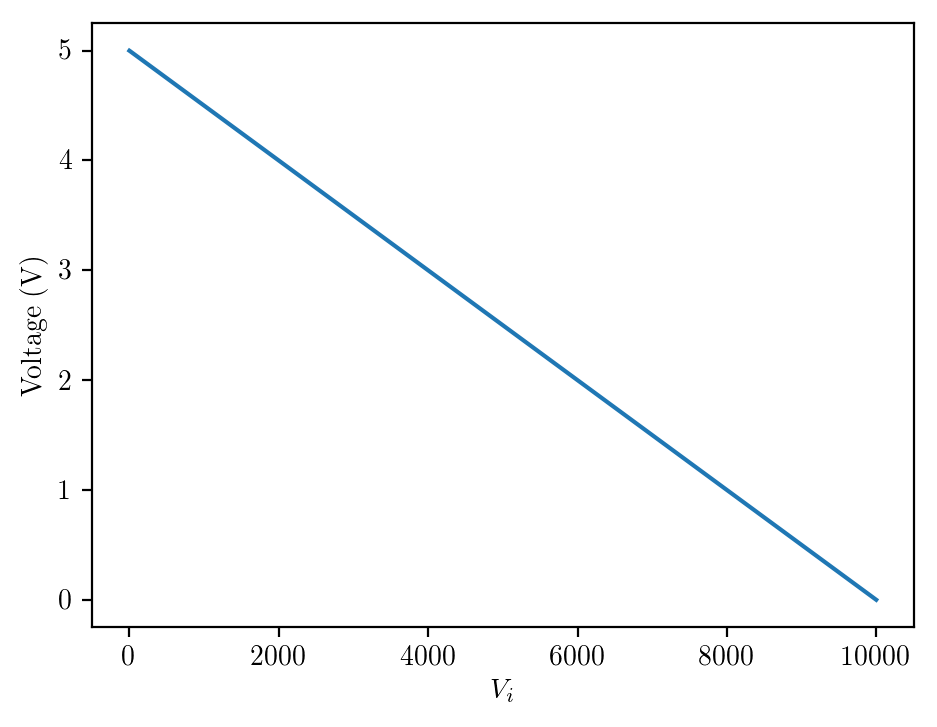

In [18]:
fig2,ax2 = plt.subplots(1,1)

ax2.plot(np.arange(0,N),x)
ax2.set_xlabel("$V_i$")
ax2.set_ylabel("Voltage (V)")

plt.show()

***
#### (7) CP 6.8, b & c
###### *The QR algorithm to calculate eigenvectors and values*

To calculate eigenvectors/values, it is convenient to decompose a matrix $A$ into the product $QR$, where $Q$ is an orthogonal matrix and $R$ is an upper triangular matrix.

Once we have a way to do the $QR$ decomposition, we can calculate the eigenvalues as follows:
1. Create and N x N matrix $V$ to hold the eigenvectors, and initially set it to $I$.
2. Calculate the QR decomposition $A=QR$
3. Update $A$ to $A=RQ$
4. Multiply $V$ on the right by $Q$
5. Check the off diagonal elements of $A$. If they are less than some chosen tolerance $\epsilon$ then terminate. Otherwise, return to step 2.

When we are done $A$ is the matrix of eigenvalues and $Q$ is the matrix of eigenvectors.

First, I create a function to perform the QR decomposition.

In [19]:
def QR_decomposition(A):
    """Performs QR decomposition on matrix A"""
    
    # transpose A, so that we can treat columns as rows
    At = A.T
    
    # matrices to hold u and q vectors
    N = len(A)
    U = np.zeros((N,N))
    Q = np.zeros((N,N))
    
    # set first rows of U and Q
    U[0,:] = At[0,:]
    Q[0,:] = U[0,:]/np.linalg.norm(U[0,:])
    
    # calculate all the other rows of U,Q
    for i in range(1,N):
        U[i,:] = At[i,:]
        for j in range(0,i):
            U[i,:] -= np.dot(Q[j,:],At[i,:])*Q[j,:]
        Q[i,:] = U[i,:]/np.linalg.norm(U[i,:])
    
    # calculate R matrix
    R = np.zeros((N,N))
    for i in range(N):
        R[i,i] = np.linalg.norm(U[i,:])
        for j in range(i+1,N):
            R[i,j] = np.dot(Q[i,:],At[j,:])
    
    # Q from QR decomp. is transpose of our Q
    Q = Q.T
    
    return Q,R
    

Now I use the function on a test array.

In [20]:
A = np.array([[1,4,8,4],[4,2,3,7],[8,3,6,9],[4,7,9,2]])
Q,R = QR_decomposition(A)

print("Original Matrix:\n",A)
print("Q:\n",Q)
print("R:\n",R)
print("QR =\n",Q @ R)

Original Matrix:
 [[1 4 8 4]
 [4 2 3 7]
 [8 3 6 9]
 [4 7 9 2]]
Q:
 [[ 0.102  0.558  0.81   0.148]
 [ 0.406 -0.107 -0.141  0.896]
 [ 0.812 -0.381  0.23  -0.377]
 [ 0.406  0.729 -0.521 -0.179]]
R:
 [[ 9.849  6.498 10.56  11.372]
 [ 0.     5.981  8.423 -0.484]
 [ 0.     0.     2.746  3.277]
 [ 0.     0.     0.     3.116]]
QR =
 [[1. 4. 8. 4.]
 [4. 2. 3. 7.]
 [8. 3. 6. 9.]
 [4. 7. 9. 2.]]


Now I will write a function to calculate eigenvectors and eigenvalues. It uses the QR decomposition function from above.

In [21]:
# First I write a function to get the maximum off-diagonal value
def max_off_diag(A):
    """This function returns the maximum off-diagonal value
    of matrix A."""
    
    # mask to ignore diagonal
    mask = np.ones(A.shape,dtype=bool)
    np.fill_diagonal(mask,False)
    
    # get off-diag max
    max_val = A[mask].max()
    
    return max_val

def eigen(A):
    """Calculate the eigenvalues/vectors of matrix A"""
    
    # eigenvalue tolerance
    e = 1e-6
    
    # matrix for eigenvectors
    N = len(A)
    V = np.identity(N)
    
    while(max_off_diag(A) > e):
        Q,R = QR_decomposition(A)
        A = R @ Q
        V = V @ Q
    
    evals = [A[i,i] for i in range(N)]
    
    return evals,V

In [22]:
A = np.array([[1,4,8,4],[4,2,3,7],[8,3,6,9],[4,7,9,2]])
evals, evecs = eigen(A)

print("Eigenvalues/vectors:")
for i in range(len(evals)):
    print("{0:>5.2f} :".format(evals[i]),evecs[i])

Eigenvalues/vectors:
21.00 : [ 0.432 -0.384 -0.775 -0.258]
-8.00 : [ 0.384  0.432 -0.258  0.775]
-3.00 : [ 0.623  0.527  0.258 -0.516]
 1.00 : [ 0.527 -0.623  0.516  0.258]


***
#### (8) CP 6.8, b & c
###### *Energy eigenvalues of an asymmetric quantum well*

The time-independent Schr&ouml;dinger Equation is 
$$ \hat{H}\psi(x) = E\psi(x), $$ 
where $\hat{H}$ is the Hamiltonian operator, 
$$ \hat{H} = -\frac{\hbar^2}{2M} \frac{d^2}{dx^2} + V(x). $$
Assume that $V(x \leq 0)=V(x \geq L)=\infty$, but allow $V(x)$ to be otherwise arbitrary. Solutions to the eigenvalue problem can be expressed as the Fourier series
$$ \psi(x) = \sum_{n=1}^\infty \psi_n \sin{\frac{\pi n x}{L}}, $$
where $\psi_1,\ \psi_2, \dots$ are the Fourier coefficients. Plugging this into the Schr&ouml;dinger Equation:
$$ \hat{H}\left(\sum_{n=1}^\infty \psi_n \sin{\frac{\pi n x}{L}}\right) = E \left(\sum_{n=1}^\infty \psi_n \sin{\frac{\pi n x}{L}}\right). $$
Then,
$$ \sum_{n=1}^\infty \psi_n \int_0^L\sin{\frac{\pi m x}{L}}\hat{H}\sin{\frac{\pi n x}{L}}dx = E \sum_{n=1}^\infty \psi_n \int_0^L\sin{\frac{\pi m x}{L}}\sin{\frac{\pi n x}{L}}dx. $$
$$ \ $$
Note that
$$ \int_0^L\sin{\frac{\pi m x}{L}}\sin{\frac{\pi n x}{L}}dx = \delta_{mn} \frac{L}{2}. $$
Thus,
$$ \sum_{n=1}^\infty \psi_n \int_0^L\sin{\frac{\pi m x}{L}}\hat{H}\sin{\frac{\pi n x}{L}}dx = \frac{1}{2} L E \psi_m. $$
If we define 
$$ H_{mn} \equiv \frac{2}{L} \int_0^L\sin{\frac{\pi m x}{L}}\hat{H}\sin{\frac{\pi n x}{L}}dx, $$
then
$$ \sum_{n=1}^\infty H_{mn} \psi_n = E \psi_n, $$
which is just the matrix equation
$$ \mathbf{H} \psi = E \psi, $$
where $\psi$ is the vector $(\psi_1,\psi_2,\dots)$.

Let $V(x) = ax/L$. Then
$$ H_{mn} = \frac{2}{L}\int_0^L \sin{\frac{\pi m x}{L}}\left(-\frac{\hbar^2}{2M}\frac{d^2}{dx^2} + \frac{ax}{L}\right)\sin{\frac{\pi n x}{L}}dx $$
$$        = \frac{2}{L} \left[ \frac{\hbar^2}{2M} \left(\frac{\pi n}{L} \right)^2 \int_0^L \sin{\frac{\pi m x}{L}}\sin{\frac{\pi n x}{L}}dx + \frac{a}{L}\int_0^L x \sin{\frac{\pi m x}{L}}\sin{\frac{\pi n x}{L}}dx \right] $$
$$        = \frac{\hbar^2}{2M} \left(\frac{\pi n}{L} \right)^2 \delta_{mn} + 2a f(m,n), $$
where
$$ f(m,n) = 
\begin{cases}
0 \hspace{1.5in} m \neq n \ \text{and}\ m,n\ \text{are both even or odd,} \\
-\left(\frac{2}{\pi}\right)^2 \frac{mn}{(m^2-n^2)^2} \hspace{0.59in} m \neq n \ \text{and one is even, one is odd,}\\
\frac{1}{4} \hspace{1.48in} m=n.
\end{cases} $$
Notice that is real and symmetric under exchange of $m$ and $n$ (i.e. the matrix $\mathbf{H}$ is symmetric).

I will write a function to calculate $H_{mn}$, and then create a 10x10 matrix to estimate the first 10 eigenvalues.

In [23]:
hbar = 6.58212e-16 # eV*s
M = 0.511e6/9e16 # electron mass, eV/c^2
L = 5e-10 # well width, m
a = 10 # eV

def Hmn(m,n):
    """Calculate the m,n matrix element of H"""
    if m == n:
        return hbar**2/(2*M)*(np.pi*n/L)**2+a/2
    elif (m % 2 == 0 or n % 2 == 0) and (m % 2 != 0 or n % 2 != 0):
        return -2*a*(2/np.pi)**2*m*n/(m**2-n**2)**2
    else:
        return 0

In [24]:
N = 10
H = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        H[i,j] = Hmn(i+1,j+1)

evals = np.linalg.eigvalsh(H)

print("The first 10 eigenvalues are")
for i in evals:
    print("{0:>6.2f} eV".format(i))

The first 10 eigenvalues are
  5.84 eV
 11.19 eV
 18.68 eV
 29.18 eV
 42.71 eV
 59.26 eV
 78.83 eV
101.42 eV
127.02 eV
155.76 eV


***
#### (9) CP 6.16
###### *Lagrange point*

Consider a satellite between the Earth and the Moon. Adding the accelerations, we have
$$ a = \frac{GM}{r^2} - \frac{Gm}{(R-r)^2}, $$
where $M$ is the mass of the Earth, $m$ is the mass of the Moon, $r$ is the distance between the Earth and the satellite, and $R$ is the distance from the Earth to the Moon. If we assume the orbit is a circle, we can use the centripetal acceleration $a_c = \omega^2 r$. Then
$$ \frac{GM}{r^2} - \frac{Gm}{(R-r)^2} = \omega^2 r, $$
or
$$ (GM-\omega^2r^3)(R-r)^2 -Gmr^2=0. $$
I will solve this final equation using the secant method to find the Lagrange point.

In [25]:
# define the function
G = 6.674e-11 # m^3/(kg*s^2)
M = 5.974e24 # kg
m = 7.348e22 # kg
R = 3.844e8 # m
w = 2.662e-6 # 1/s

f = lambda r: (G*M-w**2*r**3)*(R-r)**2-G*m*r**2

In [26]:
# solve with the secant method

# initial guesses
x1 = 1e8
x2 = 2e8

# difference/error estimate
delta = x2-x1

# iterate until tolerance reached
tolerance = 1e3
while(abs(delta) > tolerance):
    
    f1 = f(x1)
    f2 = f(x2)
    
    x3 = x2 - f2*(x2-x1)/(f2-f1)
    
    delta = x3 - x2
    x1 = x2
    x2 = x3
    
print("L1 is located at {0:.0f} km".format(x3/1e3))

L1 is located at 326045 km
